# **Tech Challenge 2 - Previsão Ibovespa**

# **1. Importações**

In [2]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Modelos clássicos
from sklearn.dummy import DummyClassifier

# XGBoost (modelo de ML)
from xgboost import XGBClassifier

# Séries temporais
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pmdarima as pm

# Prophet
from prophet import Prophet

# Configurações
plt.style.use("seaborn-v0_8")


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## **2. Carregamento dos Dados (CSV)**

Arquivo extraído do Investing.com com dados diários do Ibovespa.

Datas extraídas:
**01.01.2020 - 01.12.2025**

In [6]:
path = "data/dados_ibovespa.csv"

df = pd.read_csv(path)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.12.2025,158.611,159.073,159.224,158.029,"7,50B","-0,29%"
1,28.11.2025,159.072,158.358,159.689,158.078,"8,02B","0,45%"
2,27.11.2025,158.360,158.554,158.864,158.167,"4,47B","-0,12%"
3,26.11.2025,158.555,155.915,158.714,155.914,"8,60B","1,70%"
4,25.11.2025,155.910,155.278,156.373,154.821,"6,93B","0,41%"


# **3. Pré-Processamento dos Dados**

In [7]:
# Converter data
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Ordenar temporalmente
df = df.sort_values('Data').reset_index(drop=True)

# Converter colunas numéricas
for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# Converter variação percentual
df['Var%'] = (
    df['Var%']
    .str.replace('%', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float) / 100
)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1476 non-null   datetime64[ns]
 1   Último    1476 non-null   float64       
 2   Abertura  1476 non-null   float64       
 3   Máxima    1476 non-null   float64       
 4   Mínima    1476 non-null   float64       
 5   Vol.      1476 non-null   object        
 6   Var%      1476 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 80.8+ KB


## **4. Análise Exploratória (EDA)**


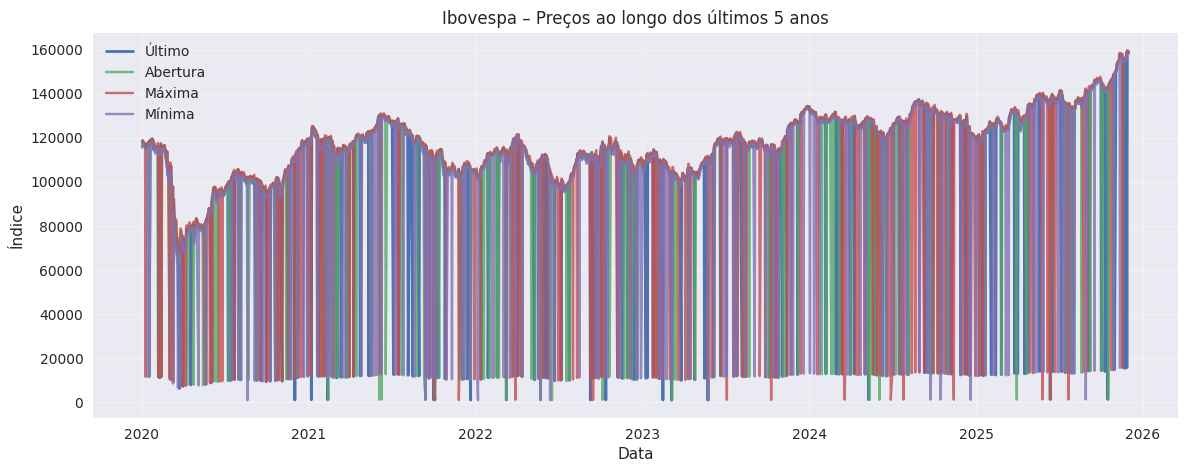

In [10]:
plt.figure(figsize=(14,5))

plt.plot(df['Data'], df['Último'], label='Último', linewidth=2)
plt.plot(df['Data'], df['Abertura'], label='Abertura', alpha=0.8)
plt.plot(df['Data'], df['Máxima'], label='Máxima', alpha=0.8)
plt.plot(df['Data'], df['Mínima'], label='Mínima', alpha=0.8)

plt.title("Ibovespa – Preços ao longo dos últimos 5 anos")
plt.xlabel("Data")
plt.ylabel("Índice")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## **5. Engenharia de Atributos**

In [11]:
# Retorno diário
df['Retorno_1'] = df['Último'].pct_change()

# Lags
df['Lag_1'] = df['Último'].shift(1)

# Médias móveis
df['Media_5'] = df['Último'].rolling(5).mean()
df['Media_10'] = df['Último'].rolling(10).mean()

# Volatilidade
df['Vol_5'] = df['Retorno_1'].rolling(5).std()


## **6. Definindo o Target**

In [12]:
# Target: sobe (1) ou cai (0) no dia seguinte
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# Remover NaNs
df = df.dropna().reset_index(drop=True)

df[['Data','Último','Target']].tail()


,Data,Último,Target
1462,2025-11-25,15591.0,1
1463,2025-11-26,158555.0,0
1464,2025-11-27,15836.0,1
1465,2025-11-28,159072.0,0
1466,2025-12-01,158611.0,0


## **7. Definindo Base de Teste**

Split temporal = Últimos 30 dias

In [13]:
FEATURES = ['Retorno_1','Lag_1','Media_5','Media_10','Vol_5']

X = df[FEATURES]
y = df['Target']

X_train = X.iloc[:-30]
X_test  = X.iloc[-30:]

y_train = y.iloc[:-30]
y_test  = y.iloc[-30:]


## **Modelos**

Os Modelos escolhidos para avaliação são:
- Baseline — Naive
- Seasonal Naive
- XGBoost
- AutoArima
- Prophet

### **Baseline (Naive)**

In [14]:
naive = DummyClassifier(strategy="most_frequent")
naive.fit(X_train, y_train)

pred_naive = naive.predict(X_test)
acc_naive = accuracy_score(y_test, pred_naive)

print(f"Naive Accuracy: {acc_naive:.2%}")


Naive Accuracy: 60.00%


### **Seasonal Naive**

In [15]:
# Prevê o mesmo movimento do dia anterior
seasonal_pred = y.shift(1).iloc[-30:]
acc_seasonal = accuracy_score(y_test, seasonal_pred)

print(f"Seasonal Naive Accuracy: {acc_seasonal:.2%}")


Seasonal Naive Accuracy: 56.67%


### **XGBoost**

In [16]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.2%}")


XGBoost Accuracy: 50.00%


### **AutoARIMA**

In [17]:
# Modelo ARIMA no fechamento
arima = pm.auto_arima(
    df['Último'][:-30],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True
)

forecast_arima = arima.predict(n_periods=30)

# Direção prevista
last_price = df['Último'].iloc[-31]
pred_dir_arima = (forecast_arima > last_price).astype(int)

acc_arima = accuracy_score(y_test.values, pred_dir_arima)
print(f"AutoARIMA Accuracy: {acc_arima:.2%}")


AutoARIMA Accuracy: 40.00%


### **Prophet**

In [18]:
prophet_df = df[['Data','Último']].rename(columns={'Data':'ds','Último':'y'})

train_prophet = prophet_df.iloc[:-30]

model_prophet = Prophet(daily_seasonality=False)
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

pred_prophet = forecast['yhat'].iloc[-30:].values
real_last = df['Último'].iloc[-31:-1].values

pred_dir_prophet = (pred_prophet > real_last).astype(int)

acc_prophet = accuracy_score(y_test.values, pred_dir_prophet)
print(f"Prophet Accuracy: {acc_prophet:.2%}")


02:05:37 - cmdstanpy - INFO - Chain [1] start processing
02:05:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet Accuracy: 36.67%


## **Comparação Final**

In [19]:
resultados = pd.DataFrame({
    'Modelo': ['Naive','Seasonal Naive','XGBoost','AutoARIMA','Prophet'],
    'Acurácia': [
        acc_naive,
        acc_seasonal,
        acc_xgb,
        acc_arima,
        acc_prophet
    ]
}).sort_values(by='Acurácia', ascending=False)

resultados


,Modelo,Acurácia
0,Naive,0.600000
1,Seasonal Naive,0.566667
2,XGBoost,0.500000
3,AutoARIMA,0.400000
4,Prophet,0.366667


### **Melhor Modelo**

In [20]:
best_model = resultados.iloc[0]['Modelo']
print(f"Melhor modelo: {best_model}")

print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

Melhor modelo: Naive
[[ 7  5]
 [10  8]]
              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.62      0.44      0.52        18

    accuracy                           0.50        30
   macro avg       0.51      0.51      0.50        30
weighted avg       0.53      0.50      0.50        30



Previsão (apenas dias úteis)

Definindo a frequência de atualização como B (Business Days), pois o Ibovespa atualiza apenas nos dias úteis

In [56]:
future = model.make_future_dataframe(
    periods=test_days,
    freq="B"  # Business days (dias úteis)
)

forecast = model.predict(future)

Unindo Previsão com valores Reais

In [57]:
forecast_test = forecast[["ds", "yhat"]].iloc[-test_days:].reset_index(drop=True)
test = test.reset_index(drop=True)

test = pd.concat([test, forecast_test["yhat"]], axis=1)


Definindo a acurácia como Maior (>) ou Menor (<)

In [61]:
test["target"] = np.where(
    test["y"] > test["y"].shift(1),
    1,
    0
)

test["pred_direction"] = np.where(
    test["yhat"] > test["yhat"].shift(1),
    1,
    0
)

test = test.dropna(subset=["target", "pred_direction"]) # Removendo Nulos

Acurácia

In [64]:
accuracy = accuracy_score(
    test["target"].astype(int),
    test["pred_direction"].astype(int)
)

print(f"Acurácia direcional: {accuracy:.2%}")

if accuracy >= 0.75:
    print("Modelo aprovado (>= 75%)")
else:
    print("Modelo abaixo de 75%")

Acurácia direcional: 53.33%
Modelo abaixo de 75%


Visualização 

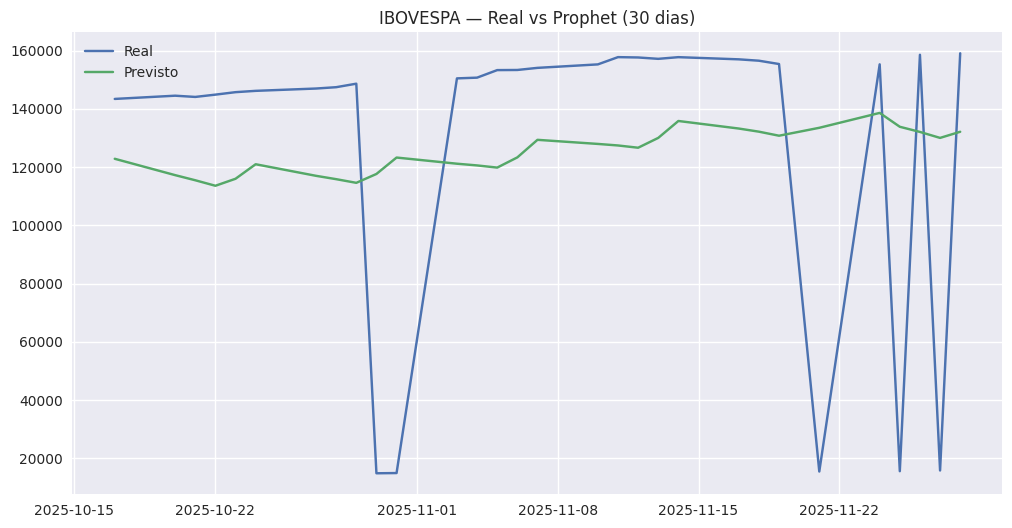

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test["ds"], test["y"], label="Real")
plt.plot(test["ds"], test["yhat"], label="Previsto")
plt.legend()
plt.title("IBOVESPA — Real vs Prophet (30 dias)")
plt.show()